In [12]:
# # Display plots inline and change default figure size
# %matplotlib inline

# Package imports
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
from pandas_datareader import data as datard
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import yfinance


In [13]:

def get_stock_dataframe(ticker , startDate , endDate):
  #Get the stock
  df = datard.DataReader(ticker, 'stooq', startDate, endDate)
  #Reverse the data frame
  df = df.iloc[::-1]
  return df
  
ticker = 'MSFT'
endDate = pd.to_datetime('today')
startDate = endDate - timedelta(days = 365 * 32 )

df = yfinance.download(ticker , startDate , endDate )
# df = get_stock_dataframe(ticker , startDate , endDate , i)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-03-20,0.809028,0.810764,0.781250,0.784722,0.494390,92145600
1990-03-21,0.783854,0.802083,0.779514,0.786458,0.495484,69840000
1990-03-22,0.788194,0.789931,0.765625,0.772569,0.486733,92419200
1990-03-23,0.777778,0.786458,0.756944,0.765625,0.482358,53596800
1990-03-26,0.767361,0.781250,0.766493,0.774306,0.487827,55929600
...,...,...,...,...,...,...
2022-03-07,288.529999,289.690002,278.529999,278.910004,278.910004,43157200
2022-03-08,277.799988,283.959991,270.000000,275.850006,275.850006,48159500
2022-03-09,283.440002,289.600006,280.779999,288.500000,288.500000,35204500


In [14]:
resampled_data = df.resample('60T', closed='right', label='right').agg({'Open': 'first',
                                                                         'High': 'max',
                                                                         'Low': 'min',
                                                                         'Close': 'last'}).dropna()


In [15]:
from scipy.signal import argrelextrema

def get_max_min(prices, smoothing, window_range):
    smooth_prices = prices['Close'].rolling(window=smoothing).mean().dropna()
    local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    local_min = argrelextrema(smooth_prices.values, np.less)[0]
    price_local_max_dt = []

    for i in local_max:
        if (i>window_range) and (i<len(prices)-window_range):
            price_local_max_dt.append(prices.iloc[i-window_range:i+window_range]['Close'].idxmax())
    price_local_min_dt = []
    for i in local_min:
        if (i>window_range) and (i<len(prices)-window_range):

            price_local_min_dt.append(prices.iloc[i-window_range:i+window_range]['Close'].idxmin())  

    maxima = pd.DataFrame(prices.loc[price_local_max_dt])
    minima = pd.DataFrame(prices.loc[price_local_min_dt])
    max_min = pd.concat([maxima, minima]).sort_index()
    max_min.index.name = 'date'
    max_min = max_min.reset_index()
    max_min = max_min[~max_min.date.duplicated()]

    p = prices.reset_index()   
    max_min['day_num'] = p[p['Date'].isin(max_min.date)].index.values
    max_min = max_min.set_index('day_num')['Close']
    
    return max_min

smoothing = 3
window = 10

minmax = get_max_min(df, smoothing, window)


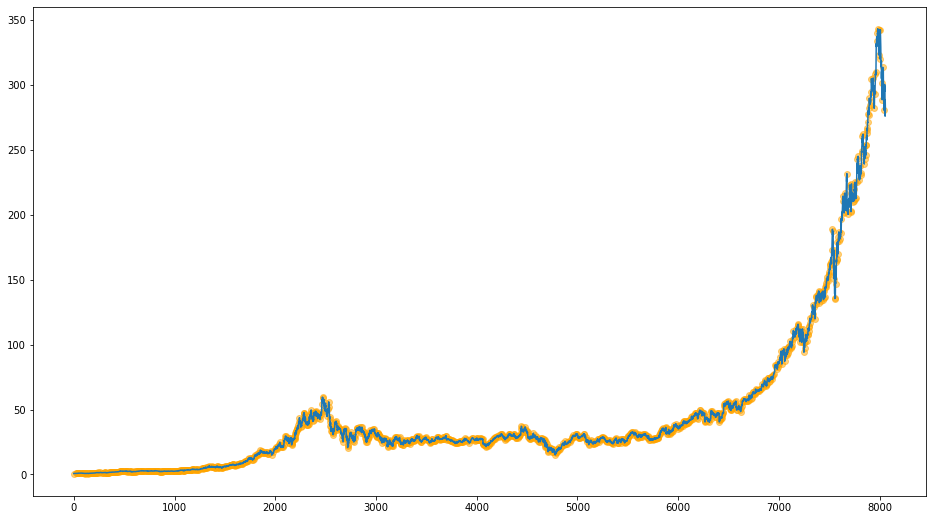

In [16]:
plt.figure(figsize=(16,9))
plt.plot(resampled_data.reset_index()['Close'])
plt.scatter(minmax.index , minmax.values , color='orange' , alpha=.5)


In [17]:
from collections import defaultdict

def find_patterns(max_min):  
    patterns = defaultdict(list)
    
    # Window range is 5 units
    for i in range(5, len(max_min)):  
        window = max_min.iloc[i-5:i]
        
        # Pattern must play out in less than n units
        if window.index[-1] - window.index[0] > 100:      
            continue   
            
        a, b, c, d, e = window.iloc[0:5]
                
        # IHS
        if a<b and c<a and c<e and c<d and e<d and abs(b-d)<=np.mean([b,d])*0.02:
               patterns['IHS'].append((window.index[0], window.index[-1]))
        
    return patterns

patterns = find_patterns(minmax)



In [25]:
def plot_minmax_patterns(prices, max_min, patterns, stock, window, ema):
    
    incr = str((prices.index[1] - prices.index[0]).seconds/60)
    
    if len(patterns) == 0:
        pass
    else:
        num_pat = len([x for x in patterns.items()][0][1])
        f, axes = plt.subplots(1, 2, figsize=(16, 5))
        axes = axes.flatten()
        prices_ = prices.reset_index()['Close']
        axes[0].plot(prices_)
        axes[0].scatter(max_min.index, max_min, s=100, alpha=.3, color='orange')
        axes[1].plot(prices_)
        
        for name, end_day_nums in patterns.items():
            for i, tup in enumerate(end_day_nums):
                sd = tup[0]
                ed = tup[1]
                axes[1].scatter(max_min.loc[sd:ed].index,
                              max_min.loc[sd:ed].values,
                              s=200, alpha=.3)
                plt.yticks([])
        plt.tight_layout()
        plt.title('{}: {}: EMA {}, Window {} ({} patterns)'.format(stock, incr, ema, window, num_pat))

def get_results(prices, max_min, pat, stock, ema_, window_):
    
    incr = str((prices.index[1] - prices.index[0]).seconds/60)
    
    #fw_list = [1, 12, 24, 36] 
    fw_list = [1, 2, 3]
    results = []
    if len(pat.items()) > 0:
        end_dates = [v for k, v in pat.items()][0]  
        for date in end_dates:  
            param_res = {'stock': stock,
                         'increment': incr,
                         'ema': ema_,
                         'window': window_, 
                         'date': date}
            for x in fw_list:
                returns = (prices['Close'].pct_change(x).shift(-x).reset_index(drop=True).dropna())
                try:
                    param_res['fw_ret_{}'.format(x)] = returns.loc[date[1]]   
                except Exception as e:
                    param_res['fw_ret_{}'.format(x)] = e
            results.append(param_res)  
    else:
        param_res = {'stock': stock,
                     'increment': incr,
                     'ema': ema_,
                     'window': window_,
                     'date': None}
        for x in fw_list:
            param_res['fw_ret_{}'.format(x)] = None   
        results.append(param_res)
    return pd.DataFrame(results)

def screener(stock_data, ema_list, window_list, plot, results):
    
    all_results = pd.DataFrame()
    
    # for stock in stock_data:
    #     prices = stock_data.iloc[stock]
    prices = stock_data
    for ema_ in ema_list:
        for window_ in window_list: 
            max_min = get_max_min(prices, smoothing=ema_, window_range=window_)
            pat = find_patterns(max_min)
            
            if plot == True:
                plot_minmax_patterns(prices, max_min, pat, 'AAPL', window_, ema_)
                
            if results == True:
                all_results = pd.concat([all_results, get_results(prices, max_min, pat, 'AAPL', ema_, window_)], axis=0)
                
    if results == True:
        return all_results.reset_index(drop=True)

defaultdict(<class 'list'>, {'IHS': [(224, 272), (1883, 1918), (2841, 2877), (3813, 3875), (3988, 4037), (5536, 5583), (5713, 5749), (5987, 6018), (6222, 6256), (6790, 6824), (6992, 7058), (7385, 7415)]})
defaultdict(<class 'list'>, {'IHS': [(2338, 2403), (7010, 7058), (7385, 7442)]})
defaultdict(<class 'list'>, {'IHS': [(939, 1019)]})
defaultdict(<class 'list'>, {'IHS': [(706, 784), (3598, 3618), (5987, 6018), (6511, 6582)]})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {'IHS': [(1874, 1920), (2232, 2294), (5408, 5451), (5533, 5583), (6466, 6518)]})
defaultdict(<class 'list'>, {'IHS': [(5097, 5155)]})
defaultdict(<class 'list'>, {})


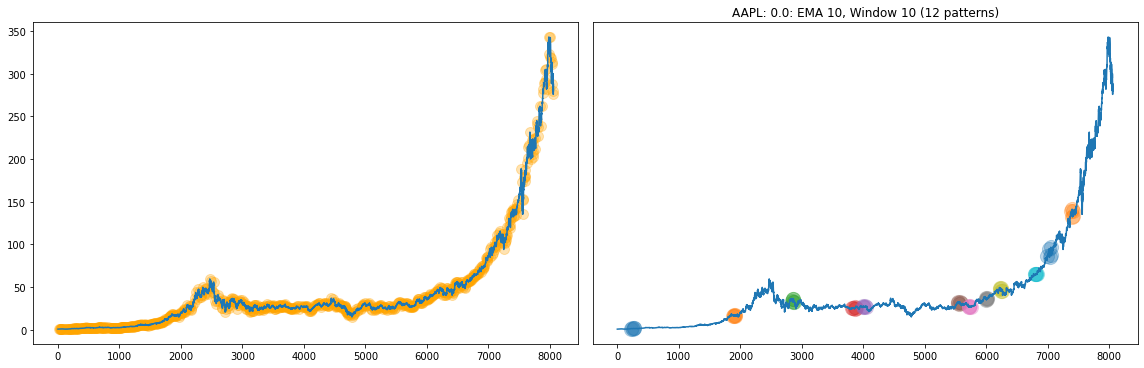

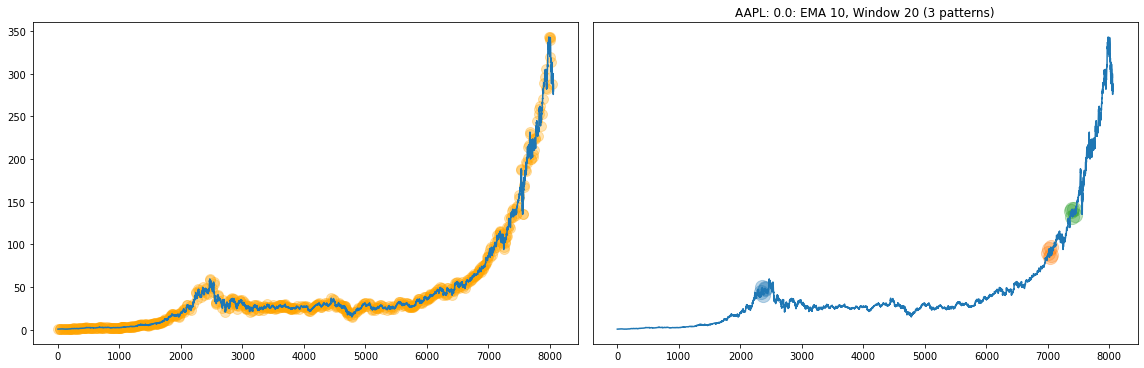

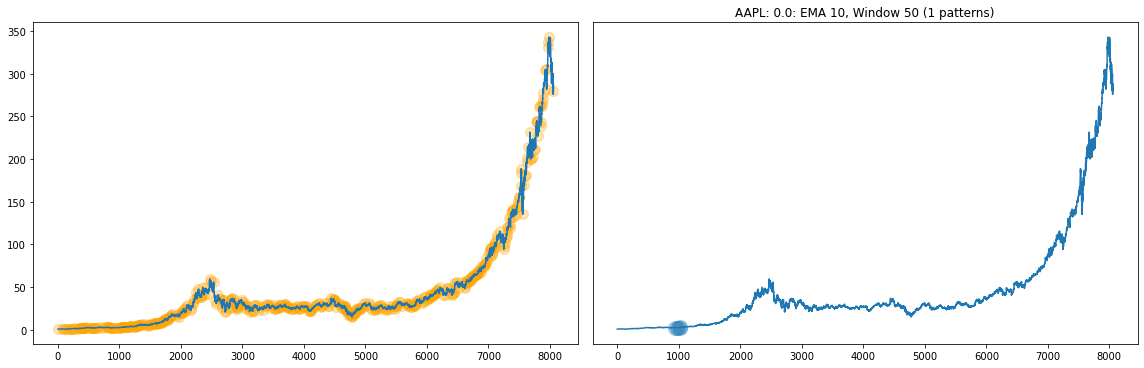

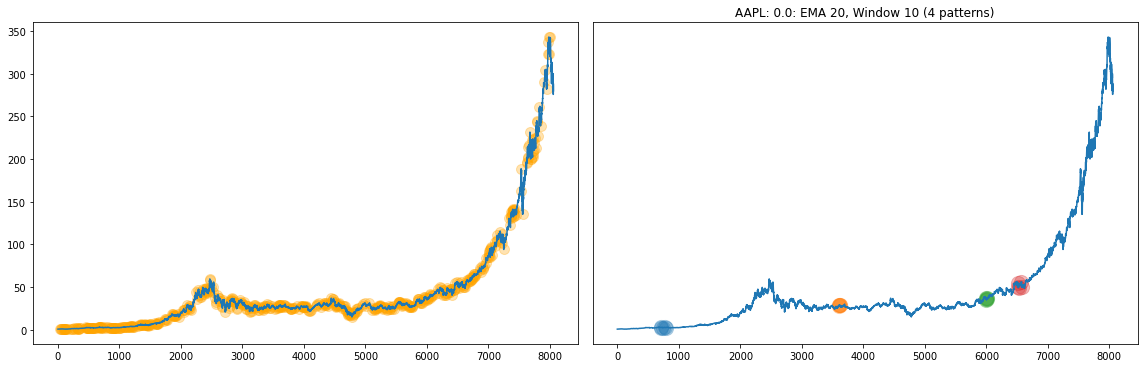

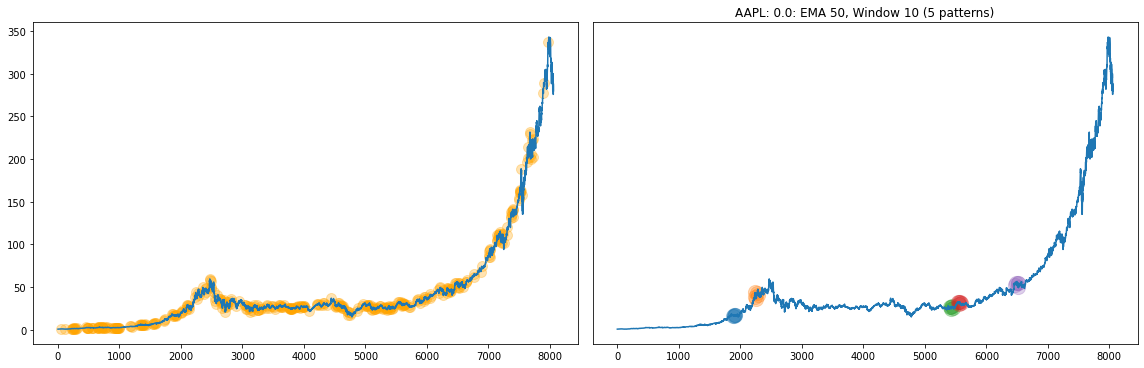

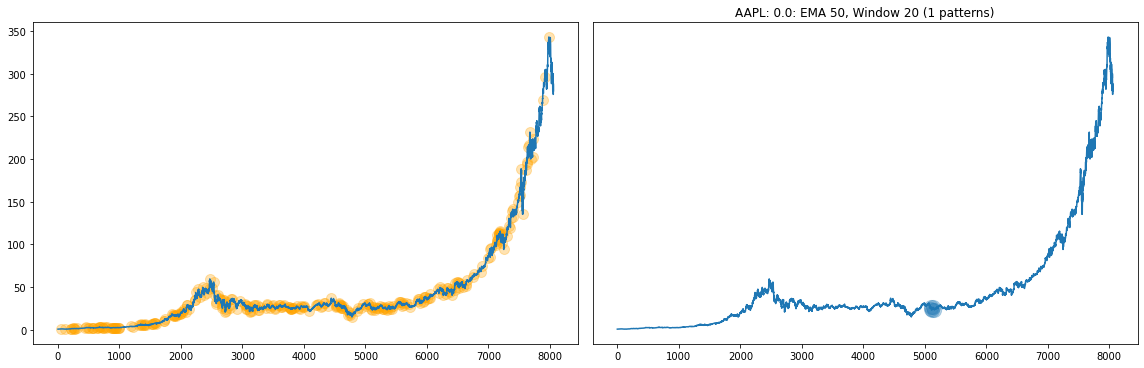

In [26]:
ema_list = [10 , 20 , 50]
window_list = [10 , 20 , 50]

results = screener(resampled_data , ema_list , window_list , True, True)

In [21]:
results

,stock,increment,ema,window,date,fw_ret_1,fw_ret_2,fw_ret_3
0,AAPL,0.0,10,10,"(224, 272)",-0.013453,-0.038117,-0.084081
1,AAPL,0.0,10,10,"(1883, 1918)",0.002836,0.047259,0.025992
2,AAPL,0.0,10,10,"(2841, 2877)",0.002313,0.010176,0.014955
3,AAPL,0.0,10,10,"(3813, 3875)",0.034336,0.051312,0.054012
4,AAPL,0.0,10,10,"(3988, 4037)",0.005959,0.005959,0.001862
5,AAPL,0.0,10,10,"(5536, 5583)",-0.015404,-0.030488,-0.040436
6,AAPL,0.0,10,10,"(5713, 5749)",0.013983,0.016251,0.028345
7,AAPL,0.0,10,10,"(5987, 6018)",0.01005,0.020659,0.027359
8,AAPL,0.0,10,10,"(6222, 6256)",0.016711,0.020009,0.009675
9,AAPL,0.0,10,10,"(6790, 6824)",0.007073,0.02091,0.038284


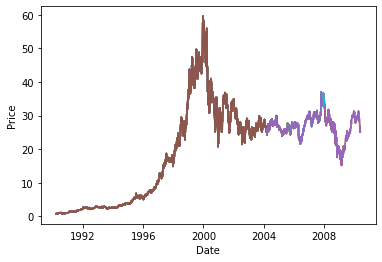

In [22]:
for i in range(len(results)):
    if (results.iloc[i]['date'] != None):
        start , end = results.iloc[i]['date']
        plt.plot(df[(df.index < startDate + timedelta(days = int(start)) ) & (df.index < startDate + timedelta(days = int(end)))]['Close'])
        plt.xlabel('Date')
        plt.ylabel('Price')